<a href="https://colab.research.google.com/github/toomahawkk/Felix-Code/blob/master/MLGradientBoostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://stackoverflow.com/questions/52385655/unable-to-locate-package-google-drive-ocamlfuse-suddenly-stopped-working
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from pandas.api.types import is_string_dtype

from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

from google.colab import files
uploaded = files.upload()

import io
train = pd.read_csv(io.BytesIO(uploaded['dataNextGem.csv']))
#Dataset is now stored in a Pandas Dataframe

Saving dataNextGem.csv to dataNextGem (1).csv


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


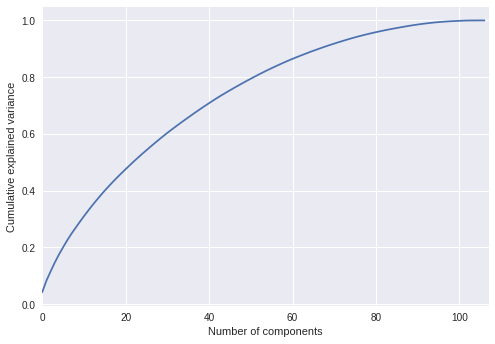

In [0]:
# Drop useless parameters 
train.drop(labels = ["id","prmW"], axis = 1, inplace = True)

#fill in flag columns with 0 (for NaNs)
train[train.columns[107:125]]=train[train.columns[107:125]].fillna(0)
train[train.columns[59:75]]=train[train.columns[59:75]].fillna(0)
train[train.columns[27:57]]=train[train.columns[27:57]].fillna(0)

###fill nan values with respective column mean
train = train.fillna(train.median())
"""
#Check which column contains strings
for column in train:   
    if is_string_dtype(train[column])==True:
        print(column)
"""
#split dataset into explanatory variables and label
Y_train = train["outcome1"].astype(int)
outcome_flags = train.iloc[:,108:125]
X_train = train.drop(train.columns[107:125], axis=1)


#Standardization
X_std2 = StandardScaler().fit_transform(X_train)
X_std = pd.DataFrame(X_std2, columns = X_train.columns)

#Principal Component Analysis
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,107,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

# ~75 components suffice for ~90% total variance
sklearn_pca = PCA(n_components=75)
X_sklearn = sklearn_pca.fit_transform(X_std)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'f1 scores (cross-validation)')

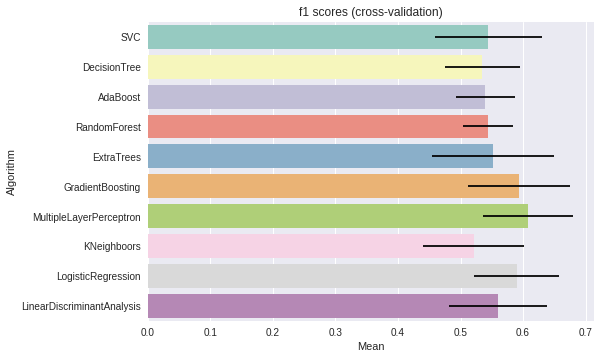

In [0]:
# PCA & Standardization
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_sklearn, y = Y_train, scoring = 'f1_macro', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

#g = plt.subplots()   
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean")
g.set_title("f1 scores (cross-validation)")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'f1 scores (cross-validation)')

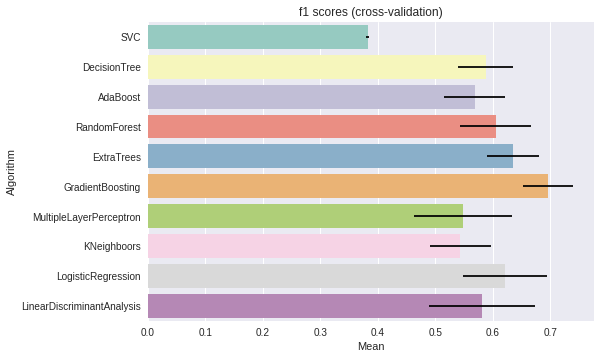

In [0]:
#WITHOUT PCA & STANDARD
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'f1_macro', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

#g = plt.subplots()   
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean")
g.set_title("f1 scores (cross-validation)")


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'f1 scores (cross-validation)')

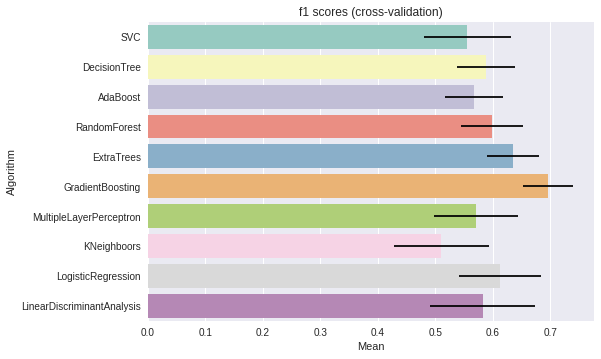

In [0]:
#WITHOUT PCA (BUT IS STANDARDIZED)
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_std, y = Y_train, scoring = 'f1_macro', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

#g = plt.subplots()   
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean")
g.set_title("f1 scores (cross-validation)")

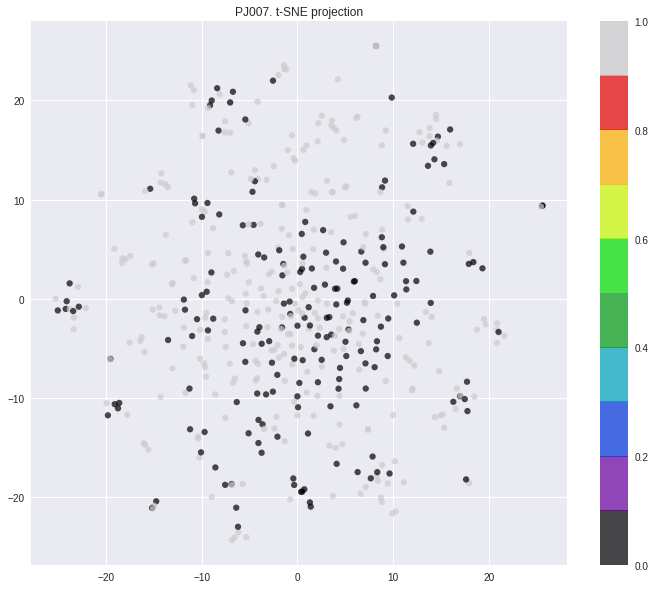

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=50)

X_tsne = tsne.fit_transform(X_sklearn)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PJ007. t-SNE projection');

In [0]:
# Gradient Boost seems best => Check overfitting of model (compare train error vs test error)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_std, Y_train, test_size=0.33, random_state=32)

gradient = GradientBoostingClassifier()
gradient.fit(X_tr, y_tr)
print("Gradient Boost")
print("Accuracy score (train data):", gradient.score(X_tr, y_tr))
print("Accuracy score (test data):", gradient.score(X_te, y_te))


Gradient Boost
Accuracy score (train data): 0.9908536585365854
Accuracy score (test data): 0.6728395061728395


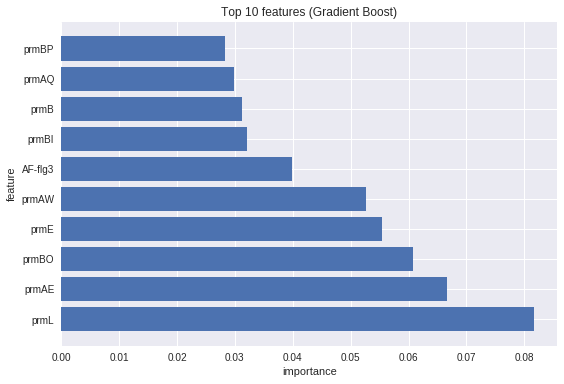

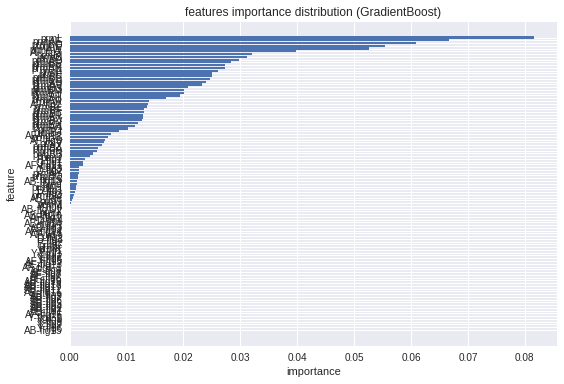

In [0]:
### Gradient Boost Feature Importances
import numpy as np

importances = gradient.feature_importances_

imp_df = pd.DataFrame({'feature': X_std.columns.values,
                       'importance': importances})

top10_df = imp_df.nlargest(10, 'importance')

## Barplot with confidence intervals
height = top10_df['importance']
bars = top10_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.subplots() 
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("importance")
plt.ylabel("feature")
plt.title("Top 10 features (Gradient Boost)")
plt.tight_layout()
# Show graphic
plt.show()    

# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')

## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.subplots() 
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("importance")
plt.ylabel("feature")
plt.title("features importance distribution (GradientBoost)")
plt.tight_layout()
# Show graphic
plt.show()    


In [0]:
# Check overfitting of model (compare train error vs test error)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_std, Y_train, test_size=0.33, random_state=32)

logistic = LogisticRegression()
logistic.fit(X_tr, y_tr)
print("Logistic Regression")
print("Accuracy score (train data):", logistic.score(X_tr, y_tr))
print("Accuracy score (test data):", logistic.score(X_te, y_te))



Logistic Regression
Accuracy score (train data): 0.823170731707317
Accuracy score (test data): 0.6234567901234568


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
